# Spotify Music Genres vs GDP Analysis 

### This notbook analyises the trends of Spotify listeners' genre preferences and if these have noticeable shifts in correlation with GDP. 

#### Contents:
- Import relevant libraries and download the dataset
- Analyse the dataset
- Brief eploratory data analysis of GDP against genre trends
- Regression analysis of GDP against genre trends
- Summary of findings, next steps and lessons learnt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
spotify_genre_df = pd.read_csv('../data/ons_genre_including_genregroup_new.csv')

In [3]:
spotify_genre_df.head()

,year_quarter,genre,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%)
0,2016 Q4,R&B,R&B,2414608.0,589476.0,1.5,369850.0,4.7
1,2016 Q4,Pop,Pop,2406621.0,589476.0,1.5,369850.0,4.7
2,2016 Q4,Pop,Pop,2345002.0,589476.0,1.5,369850.0,4.7
3,2016 Q4,Rock,Rock/Punk/Metal,1879767.0,589476.0,1.5,369850.0,4.7
4,2016 Q4,R&B,R&B,1797034.0,589476.0,1.5,369850.0,4.7


In [4]:
spotify_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year_quarter           9471 non-null   object 
 1   genre                  9471 non-null   object 
 2   Genre_Group            9471 non-null   object 
 3   streams                9471 non-null   float64
 4   gdp_(£m)               9471 non-null   float64
 5   inflation_(%)          9471 non-null   float64
 6   hfce_(£m)              9471 non-null   float64
 7   unemployment_rate_(%)  9471 non-null   float64
dtypes: float64(5), object(3)
memory usage: 592.1+ KB


#### Grouping the dataset by quarterly streams per genre to match the same frequency as economic data

In [5]:
spotify_grouped_df = spotify_genre_df.groupby(['year_quarter', 'Genre_Group']).agg({
    'streams': 'sum',
    'gdp_(£m)': 'first',
    'inflation_(%)': 'first',
    'hfce_(£m)': 'first',
    'unemployment_rate_(%)': 'first'
}).reset_index()


#### Review and analyse the data

In [6]:
spotify_grouped_df.head()

,year_quarter,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%)
0,2016 Q4,Christmas,19182659.0,589476.0,1.5,369850.0,4.7
1,2016 Q4,Dance/House,10253538.0,589476.0,1.5,369850.0,4.7
2,2016 Q4,Disco,1033984.0,589476.0,1.5,369850.0,4.7
3,2016 Q4,Electronic,7981704.0,589476.0,1.5,369850.0,4.7
4,2016 Q4,Folk,281777.0,589476.0,1.5,369850.0,4.7


In [7]:
spotify_grouped_df.tail()

,year_quarter,Genre_Group,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%)
394,2022 Q1,Rap/Hip-Hop,96795751.0,629149.0,5.5,377996.0,3.8
395,2022 Q1,Rock/Punk/Metal,66450691.0,629149.0,5.5,377996.0,3.8
396,2022 Q1,Soul,27941818.0,629149.0,5.5,377996.0,3.8
397,2022 Q1,Soundtrack,17756902.0,629149.0,5.5,377996.0,3.8
398,2022 Q1,Swing,2234121.0,629149.0,5.5,377996.0,3.8


In [8]:
spotify_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year_quarter           399 non-null    object 
 1   Genre_Group            399 non-null    object 
 2   streams                399 non-null    float64
 3   gdp_(£m)               399 non-null    float64
 4   inflation_(%)          399 non-null    float64
 5   hfce_(£m)              399 non-null    float64
 6   unemployment_rate_(%)  399 non-null    float64
dtypes: float64(5), object(2)
memory usage: 21.9+ KB


In [9]:
spotify_grouped_df.describe()

,streams,gdp_(£m),inflation_(%),hfce_(£m),unemployment_rate_(%)
count,3.990000e+02,399.000000,399.000000,399.000000,399.000000
mean,9.295545e+07,597242.894737,2.131830,366244.568922,4.300501
std,1.520043e+08,31848.242766,1.055312,24253.628557,0.414680
min,2.640990e+05,481769.000000,0.800000,286546.000000,3.700000
25%,4.093359e+06,594423.000000,1.500000,369850.000000,4.000000
50%,1.721159e+07,606396.000000,2.100000,373148.000000,4.200000
75%,1.096910e+08,615459.000000,2.600000,380204.000000,4.600000
max,7.760973e+08,629149.000000,5.500000,385054.000000,5.300000


#### Obtaining top 5 most popular genres by quarter 

In [10]:
quarterly_top5_genres = spotify_grouped_df.groupby(['year_quarter', 'Genre_Group'])['streams'].sum().reset_index()

quarterly_top5_genres = quarterly_top5_genres.groupby('year_quarter').apply(
    lambda x: x.nlargest(5, 'streams')).reset_index(drop=True)

print("Top 5 Genres by Total Streams:")
quarterly_top5_genres.head()


Top 5 Genres by Total Streams:


,year_quarter,Genre_Group,streams
0,2016 Q4,Pop,38075668.0
1,2016 Q4,Christmas,19182659.0
2,2016 Q4,R&B,13161526.0
3,2016 Q4,Rock/Punk/Metal,11896867.0
4,2016 Q4,Dance/House,10253538.0


### Plot the top 5 most streamed genres per quarter 

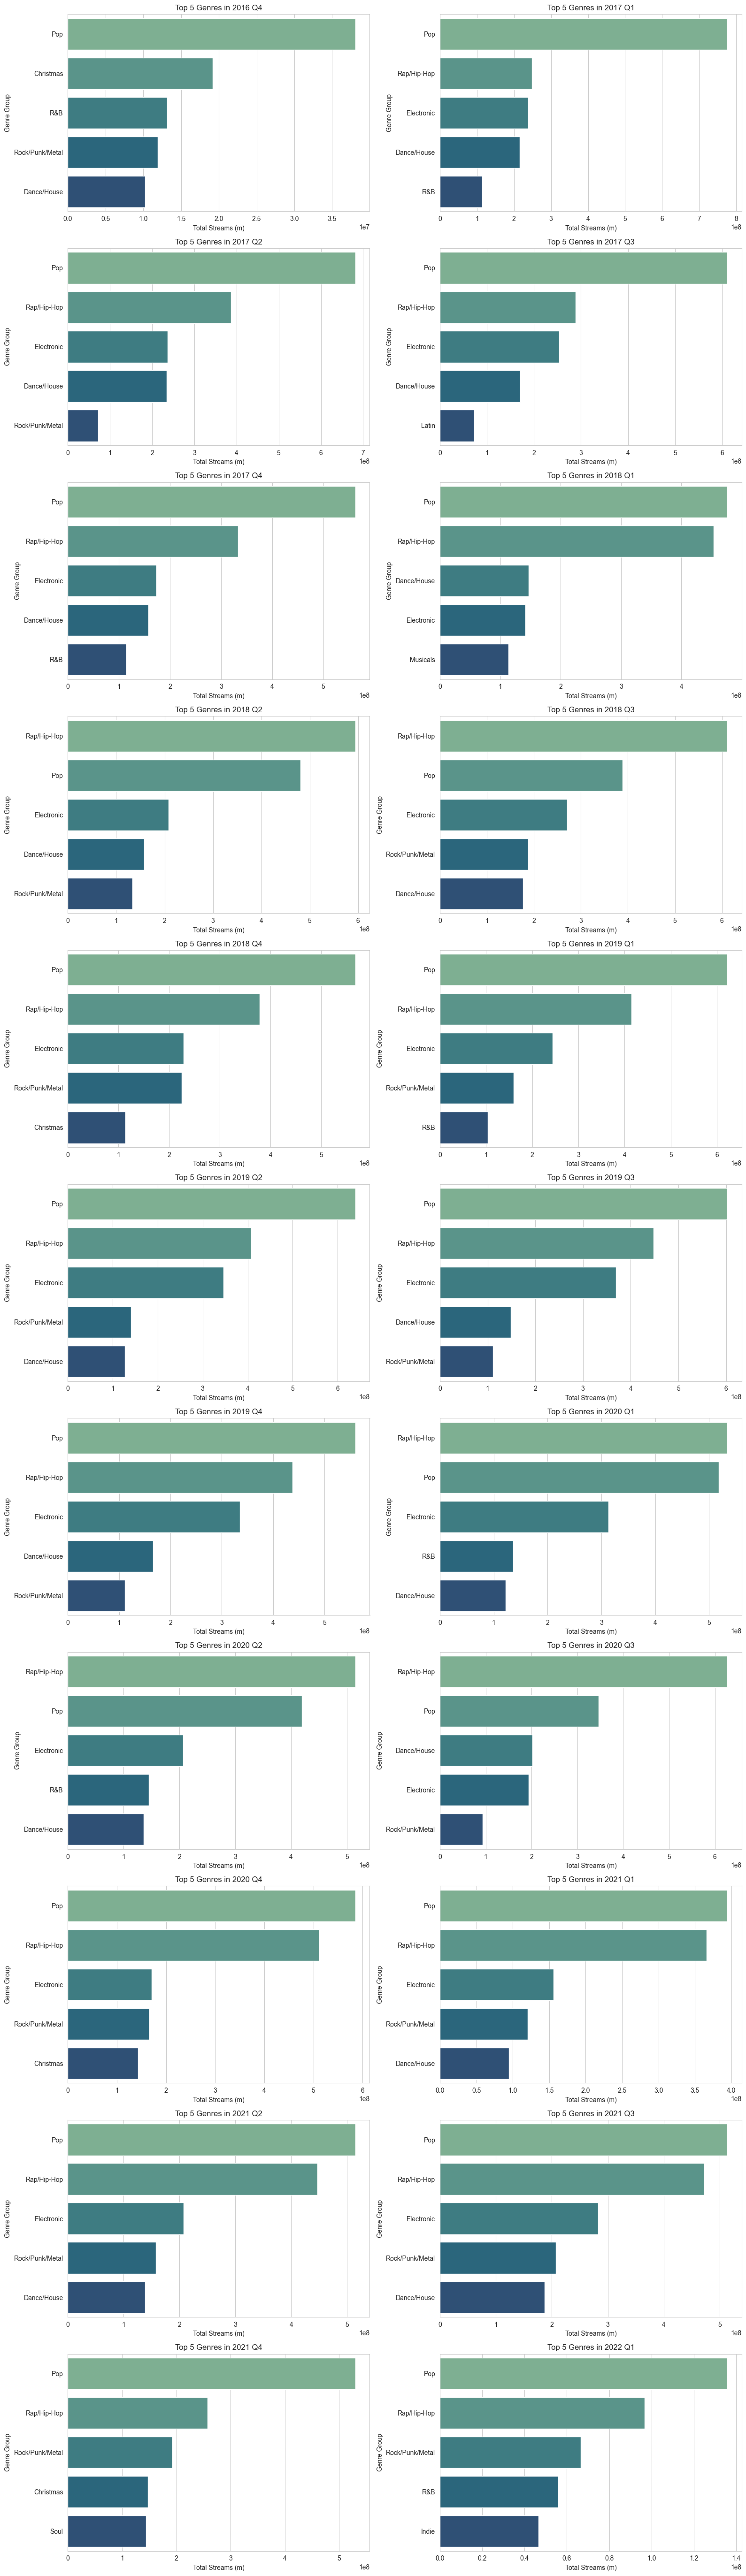

In [11]:
# creates whitebackground
sns.set_style('whitegrid')

# count unique quarters 
quarters = quarterly_top5_genres['year_quarter'].unique()
num_quarters = len(quarters)

# plots two plots per row and adjusts figure size accordingly to plots 
fig, axes = plt.subplots(nrows=(num_quarters + 1) // 2, ncols=2, figsize=(16, num_quarters * 2.5))
axes = axes.flatten()

# loop through each quarter and creates bar chart
for i, quarter in enumerate(quarters):
    ax = axes[i]
    data = quarterly_top5_genres[quarterly_top5_genres['year_quarter'] == quarter]

    # bar plot and styling 
    sns.barplot(
        data=data,
        x='streams', 
        y='Genre_Group', 
        hue='Genre_Group',      
        palette='crest',     
        ax=ax
    )
    ax.set_title(f"Top 5 Genres in {quarter}")
    ax.set_xlabel('Total Streams (m)')
    ax.set_ylabel('Genre Group')

plt.tight_layout()
plt.show()

#### Now put top 5 into pivot table

In [12]:
# group by genres adding number of streams and pulling 5 largest for top 5 and storing in variable top5 genres
top5_genres = (
    spotify_grouped_df.groupby('Genre_Group')['streams']
    .sum()
    .nlargest(5)
    .index
)

# creat filtered df for top 5 
filtered_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'].isin(top5_genres)]

# create pivot table of df to structure data for easier analysis 
pivot5_df = filtered_df.pivot_table(
    index='year_quarter',
    columns='Genre_Group',
    values='streams',
    aggfunc='sum'
)

pivot5_df = pivot5_df.sort_index()

pivot5_df.head(5)

Genre_Group,Dance/House,Electronic,Pop,Rap/Hip-Hop,Rock/Punk/Metal
year_quarter,,,,,
2016 Q4,10253538.0,7981704.0,38075668.0,10039293.0,11896867.0
2017 Q1,215870086.0,238974966.0,776097326.0,247853741.0,67154983.0
2017 Q2,233950452.0,237021087.0,681555862.0,386868632.0,71408381.0
2017 Q3,170824366.0,253981726.0,611291097.0,288801271.0,71241735.0
2017 Q4,157743587.0,173483456.0,562691589.0,333065020.0,92200080.0


#### From the plot above 'Pop' & 'Rap/Hip-Hop' are the most commonly streamed genres overall. To look into this further I would like to map out the trends of these genres' streams overtime with the unemployment line overlay to see any visible correlations.

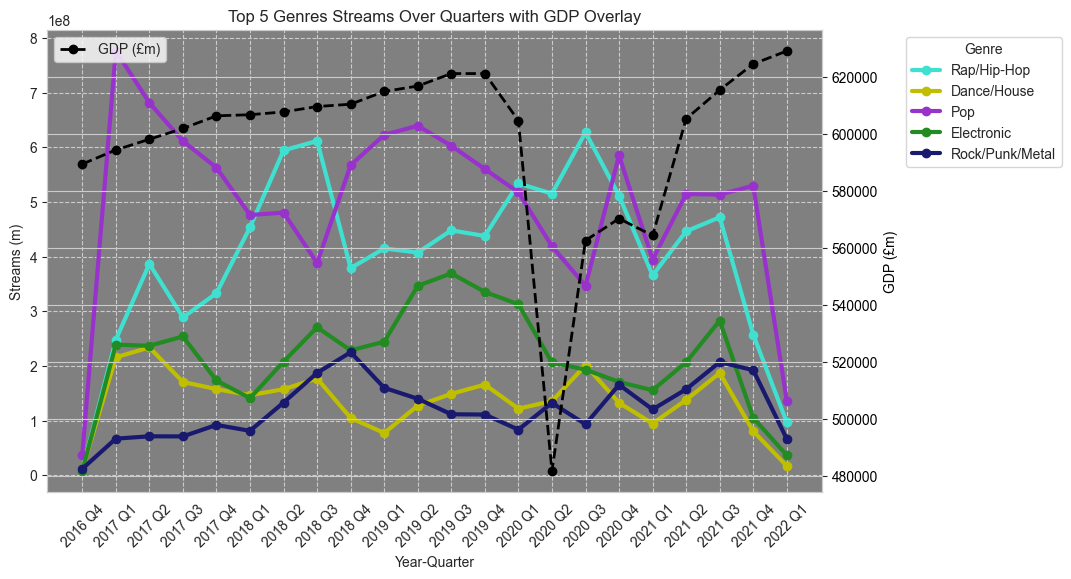

In [13]:
# this creates the figure and colours the background grey
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_facecolor('grey')

# axis 1 will plot the genre trends 
ax1.plot(pivot5_df.index, pivot5_df['Rap/Hip-Hop'], label='Rap/Hip-Hop', color='turquoise', linewidth=3, marker='o')  
ax1.plot(pivot5_df.index, pivot5_df['Dance/House'], label='Dance/House', color='y', linewidth=3, marker='o')  
ax1.plot(pivot5_df.index, pivot5_df['Pop'], label='Pop', color='darkorchid', linewidth=3, marker='o') 
ax1.plot(pivot5_df.index, pivot5_df['Electronic'], label='Electronic', color='forestgreen', linewidth=3, marker='o')  
ax1.plot(pivot5_df.index, pivot5_df['Rock/Punk/Metal'], label='Rock/Punk/Metal', color='midnightblue', linewidth=3, marker='o') 

# axis 1 labels/title/legend and styling 
ax1.set_xlabel('Year-Quarter')
ax1.set_ylabel('Streams (m)')
ax1.set_title('Top 5 Genres Streams Over Quarters with GDP Overlay')
ax1.tick_params(axis='y')
ax1.legend(title='Genre', bbox_to_anchor=(1.10, 1), loc='upper left') 
ax1.grid(linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# axis 2 will plot the unemployment line 
ax2 = ax1.twinx()

unemployment_by_quarter = spotify_grouped_df.groupby('year_quarter')['gdp_(£m)'].mean().loc[pivot5_df.index]

ax2.plot(unemployment_by_quarter.index, 
         unemployment_by_quarter.values, 
         color='black', 
         label='gdp_(£m)', 
         linestyle='--', 
         linewidth=2, 
         marker='o'
        )

# axis 2 labels and legend
ax2.set_ylabel('GDP (£m)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(['GDP (£m)'], loc='upper left')

plt.show()

### Top 5 Genres Streams Over Quarters with GDP Overlay:

#### The above plot shows little correlation with GDP, there is a slight spike in Rap/Hip-Hop, Pop and Electronic during covid but this could be down to more people streaming popular genres while stuck at home. This spike in Rap/Hip-Hop, Pop and Electronic is also inline with the first lockdown when hospitality and leisure was shut down so people could have been looking for alternative forms of entertainment. 

#### To analyse this further I'd like to look at a correlation matrix

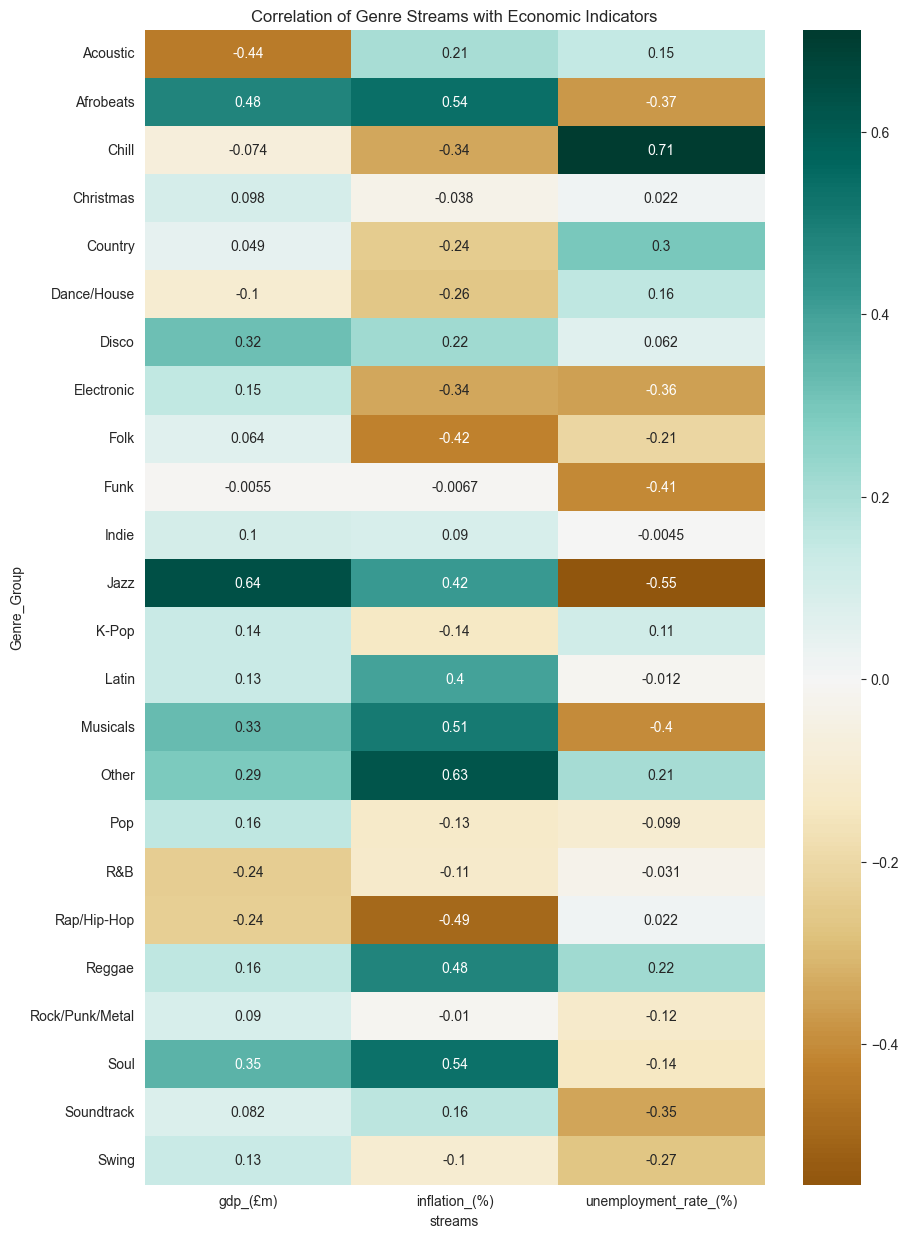

In [14]:
# groupby genre group and find correlation with .corr. 
corr_by_genre = spotify_grouped_df.groupby('Genre_Group').apply(
    lambda genre: genre[['streams', 'gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']].corr().iloc[0, 1:]
)

# plot the heatmap with seaborn and show each correlation within the cell
plt.figure(figsize=(10, 15))
sns.heatmap(corr_by_genre, annot=True, cmap="BrBG", center=0)
plt.title('Correlation of Genre Streams with Economic Indicators')
plt.show()

### Correlation Matrix with Genre Streams 

#### The biggest take aways from the matrix above is strong possitive correlation with Chill/Unemployment and Jazz/GDP. Although Electronic and GDP have a very weak correlation coefficient the plots show below the two metrics moving in a similar direction. 

In [15]:
spotify_grouped_df['Genre_Group'].unique()

array(['Christmas', 'Dance/House', 'Disco', 'Electronic', 'Folk', 'Funk',
       'Indie', 'Jazz', 'Musicals', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing', 'Chill', 'Latin',
       'Afrobeats', 'Country', 'K-Pop', 'Other', 'Acoustic'], dtype=object)

### Streams vs GDP Over Time for Dance/House:

#### There is very little correlation given 

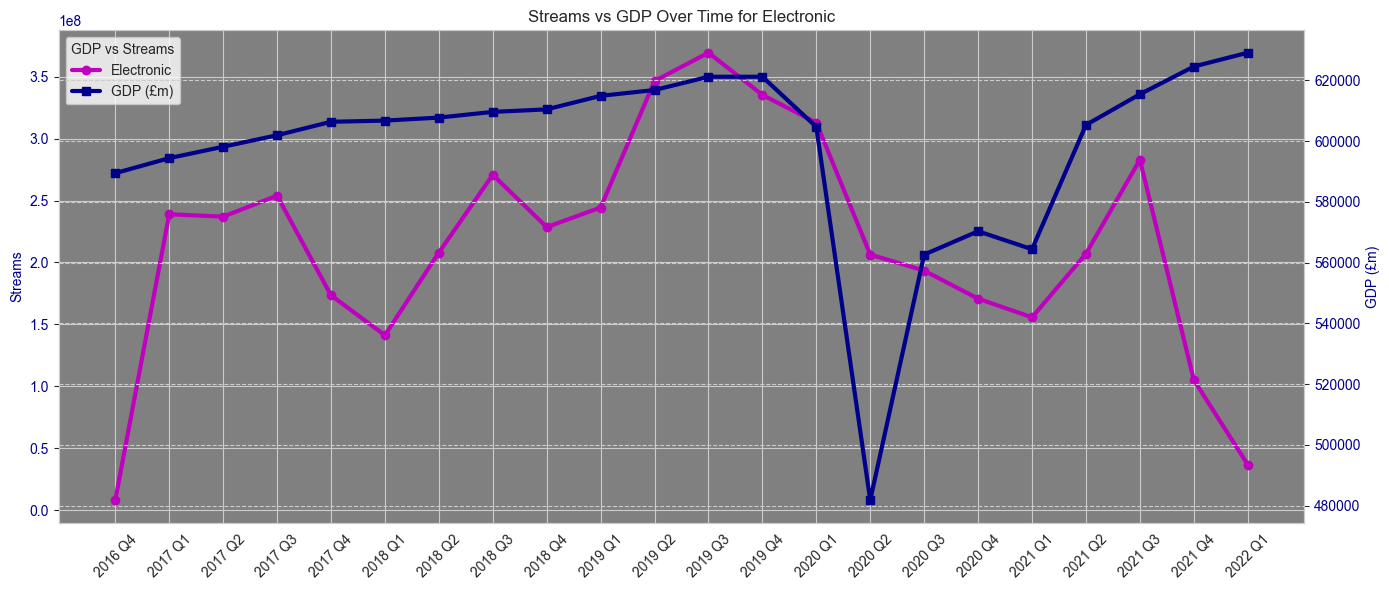

In [16]:
# filtering by electronic and sorting by quarter 
genre = 'Electronic'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

# create figure and grey background
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_facecolor('grey')

# axis 1 to plot electronic streams
ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='m', linewidth='3', marker='o', label='Electronic')
ax1.set_ylabel('Streams', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# axis 2 to plot gdp
ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['gdp_(£m)'], color='darkblue',  linewidth='3', marker='s', label='GDP (£m)')
ax2.set_ylabel('GDP (£m)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title(f'Streams vs GDP Over Time for {genre}')
ax1.tick_params(axis='x', rotation=45)

# for legend get label (gdp/electronic) from axis' plot label
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# set legend placement 
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='GDP vs Streams')


plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

### Streams vs GDP Over Time for Electronic:

#### The plot above shows a correlation with gdp and electronic steams, the correlation coefficient for electronic and gdp is very weak but they are moving in similar directions. This will be discussed further.

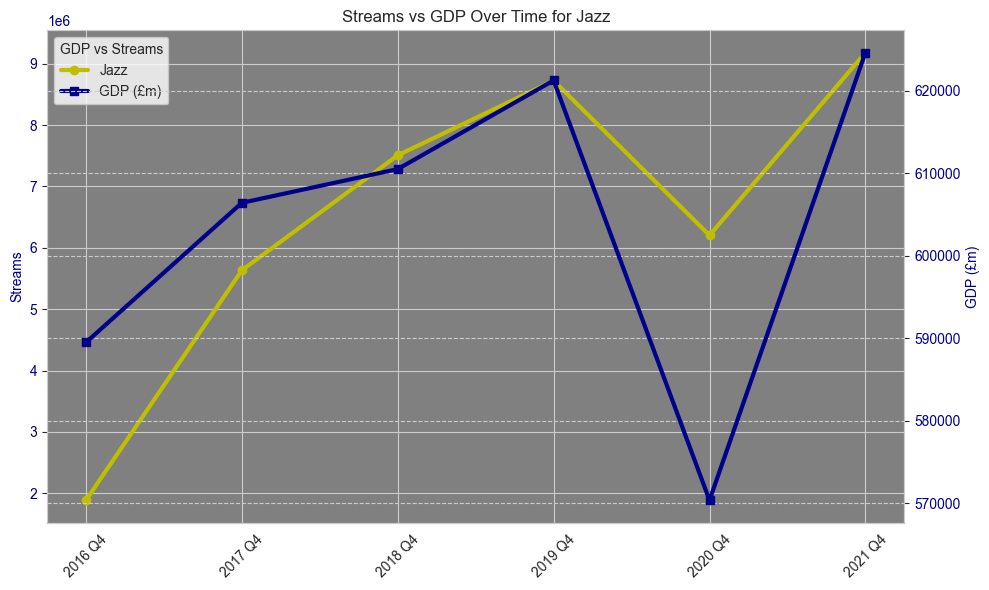

In [17]:
genre = 'Jazz'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='y', linewidth='3', marker='o', label='Jazz')
ax1.set_ylabel('Streams', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['gdp_(£m)'], color='darkblue',  linewidth='3', marker='s', label='GDP (£m)')
ax2.set_ylabel('GDP (£m)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title(f'Streams vs GDP Over Time for {genre}')
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='GDP vs Streams')


plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

### Streams vs GDP Over Time for Jazz:

#### Jazz & GDP have a medium possitive correlation and the above plot shows the two metrics moving in similar direction. However from analysing further i noticed that Jazz streams were only showing during Q4 for each year. This could be a fault with the data which would discredit this insight. If time allowed I would like to dive deeper into this with gathering further music genre data to compare. 

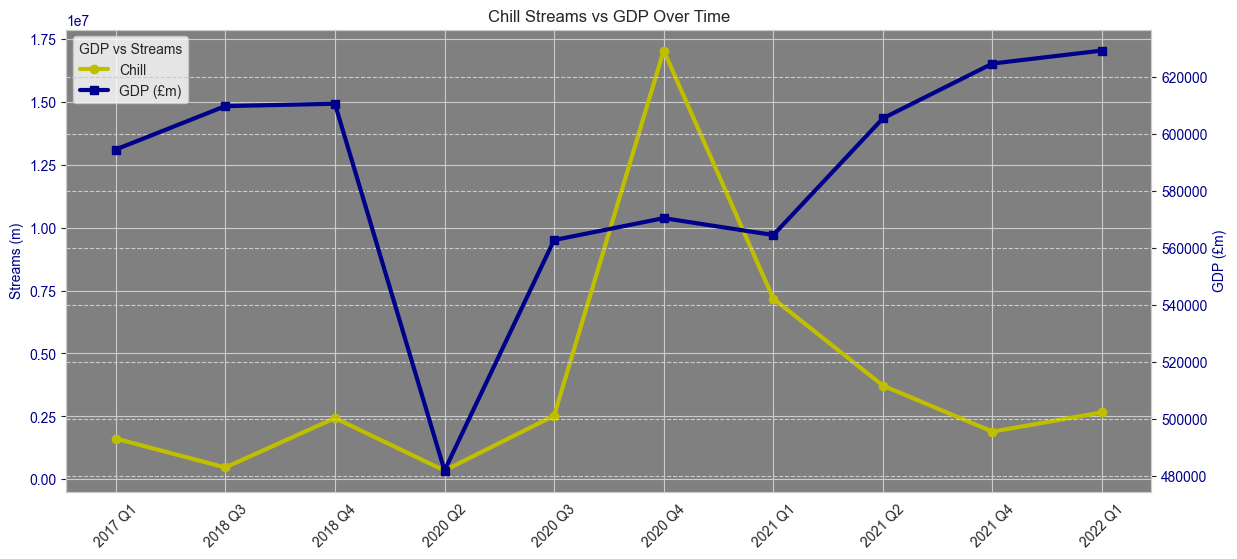

In [18]:
genre = 'Chill'
df_genre = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre].sort_values('year_quarter')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_facecolor('grey')

ax1.plot(df_genre['year_quarter'], df_genre['streams'], color='y', linewidth='3', marker='o', label='Chill')
ax1.set_ylabel('Streams (m)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_genre['year_quarter'], df_genre['gdp_(£m)'], color='darkblue', linewidth='3', marker='s', label='GDP (£m)')
ax2.set_ylabel('GDP (£m)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title(f'{genre} Streams vs GDP Over Time')
# plt.xticks(rotation=45)
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', title='GDP vs Streams')


plt.grid(linestyle='--')
# plt.tight_layout()
plt.show()

### Streams vs GDP Over Time for Chill:

#### From the plot above the two metrics have a lagged strong negative correlation. From my analysis with unemployment vs Chill there was a strong possitive correlation. As many macroeconomic factors move inline this could be a lagged effect where listeners are trying to relax during unpresedented times of economic uncertainty. If time allowed further analysis with Time Series and increasing sample size would provide more comprehensive insights. 

In [21]:
top_genres = (
    spotify_grouped_df.groupby('Genre_Group')['streams']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

genre_corrs = {}

for genre in top_genres:
    genre_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == genre][
        ['streams', 'gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']
    ]

    corr = genre_df.corr().loc['streams'][
        ['gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']
    ]
    genre_corrs[genre] = corr
 
corr_summary_df = pd.DataFrame(genre_corrs).T  
corr_summary_df.columns = ['GDP', 'Inflation', 'Unemployment']

corr_summary_df.round(2)


,GDP,Inflation,Unemployment
Pop,0.16,-0.13,-0.10
Rap/Hip-Hop,-0.24,-0.49,0.02
Electronic,0.15,-0.34,-0.36
Dance/House,-0.10,-0.26,0.16
Rock/Punk/Metal,0.09,-0.01,-0.12


## GDP & Electronic Correlation vs Pattern




<img src="../data/images/Correlation_Matrix.png" width=600px>

<img src="../data/images/GDP_Electronic_Streams.png">

### Insights from analysis:
1. Correlation Measures Linearity Only:
- Pearson correlation only captures linear relationships.
- If streams and GDP rise and fall together, but not proportionally or consistently, the correlation can be low even though they visually move in the same direction.
- In the image captured above we see a correlation of 0.15 which would suggest no correlation but in the line plot where both metrics are overlayed we see both moving in similar directions 

2. Lag Effects:
- Economic effects may impact streaming behaviour with a delay.
- If electronic music streams react to GDP changes a quarter later, a simple same-period correlation won’t capture it.

3. High Noise or Short Series:
- The dataset might contain few data points per genre (especially per quarter), or have high variability in streams due to non-economic reasons (e.g. viral hits, festivals).
- That noise can mask the underlying economic signal in correlation.

4. Scale vs Pattern:
- Correlation isn't concerned with two lines looking similar, only whether they vary together in a consistent, scaled way.
- If both lines trend upward, but one grows steadily and the other fluctuates a lot, correlation can still be low which is why we are seeing them moving in similar directions yet still have a very low correlation.

## Electronic OLS Regression vs GDP, Inflation & Unemployment:

In [22]:
genre_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Electronic'].sort_values('year_quarter')


X = genre_df[['gdp_(£m)', 'inflation_(%)', 'unemployment_rate_(%)']]
y = genre_df['streams']

# add a constant 
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     6.017
Date:                Wed, 07 May 2025   Prob (F-statistic):            0.00504
Time:                        13:19:53   Log-Likelihood:                -426.42
No. Observations:                  22   AIC:                             860.8
Df Residuals:                      18   BIC:                             865.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.205e+08   4.32e+08      0.279      0.784   -7.88e+08    1.03e+09
gdp_(£m)               1158.3496    615.297      1.883      0.076    -134.341    2451.040
inflation_(%)         -6.337e+07   1.73e+07     -3.661      0.002   -9.97e+07    -2.7e+07
unemployment_rate_(%) -1.074e+08   4.03e+07     -2.662      0.016   -1.92e+08   -2.26e+07
==============================================================================
Omnibus:                        9.838   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                7.631
Skew:                          -1.141   Prob(JB):                       0.0220
Kurtosis:                       4.766   Cond. No.                     1.74e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Electronic OLS Regression vs GDP, Inflation & Unemployment Results:

OLS Regression includes three predictors: GDP, Inflation, and Unemployment (minus HFCE as we decided to remove that due to intercorrelation with GDP). These regression results for the combined macroeconomic factors suggest the model is starting to uncover some statistically meaningful relationships.


### Key Points in the Results:
1. Model Fit (R² and Adjusted R²)
- R-squared = 0.501: the model explains 50.1% of the variance in music streams, which is a moderate and meaningful fit.
- Adjusted R² = 0.418: reasonable especially with only 22 observations indicating that the included variables are contributing real explanatory power.

2. Model Significance
- F-statistic = 6.017, p-value = 0.005: The overall model is statistically significant, meaning at least one of the predictors has a significant effect on streams.

### Interpretation of Coefficients:

<img src="../data/images/Interpretation_of_Coefficients.png">


### Conclusion: 
- Economic conditions (especially inflation and unemployment) have a statistically significant and substantial negative effect on music streaming volume.
- GDP is possibly meaningful but isn't quite statistically significant with the current sample size I would like to explore these avenues further if time allowed.
- The model explains about half the variation in streams, but there's room to improve by exploring more variables, increasing sample size, or addressing model assumptions.
- Regression analysis will be carried out in order to determine if there's a linear relationship with these variables (as the OLS regression suggests non-lineararity)


### Regression Plots for Electronic and Jazz

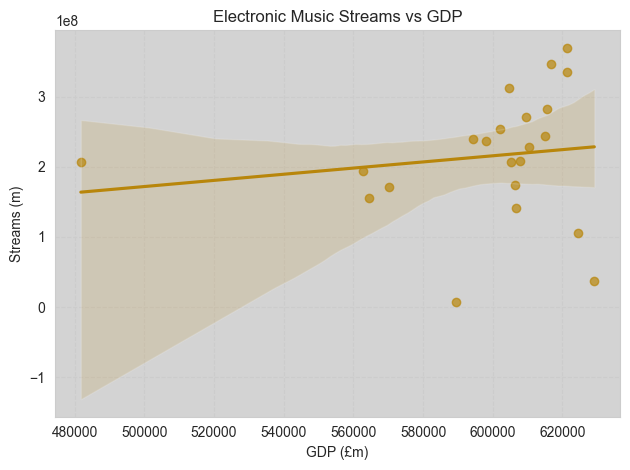

In [23]:
electronic_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Electronic'].sort_values('year_quarter')

# create seaborn regression plot with electronic streams and gdp
sns.regplot(
    data=electronic_df, 
    x='gdp_(£m)', 
    y='streams', 
    scatter_kws={'alpha':0.7}, 
    color='darkgoldenrod')

ax = plt.gca()
ax.set_facecolor("lightgrey")
plt.title('Electronic Music Streams vs GDP')
plt.xlabel('GDP (£m)')
plt.ylabel('Streams (m)')
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()


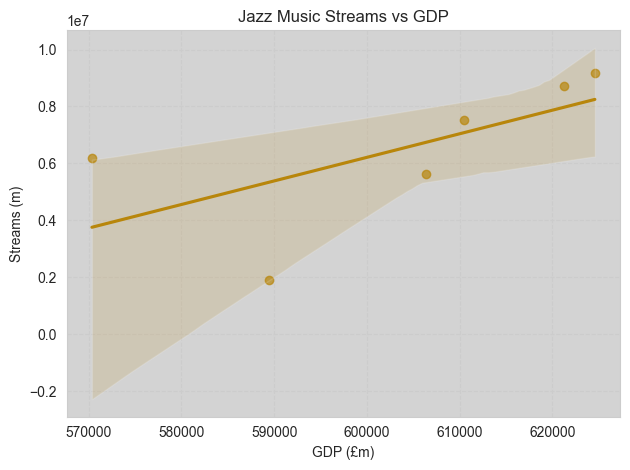

In [87]:
jazz_df = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Jazz'].sort_values('year_quarter')

sns.regplot(
    data=jazz_df, 
    x='gdp_(£m)', 
    y='streams', 
    scatter_kws={'alpha':0.7}, 
    color='darkgoldenrod')

ax = plt.gca()
ax.set_facecolor("lightgrey")
plt.title('Jazz Music Streams vs GDP')
plt.xlabel('GDP (£m)')
plt.ylabel('Streams (m)')
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()


#### The above two regression plots show very little linear relationship. A polynomial regression would be much more suited 

## Polynomial Regression Electronic and Jazz Genres 

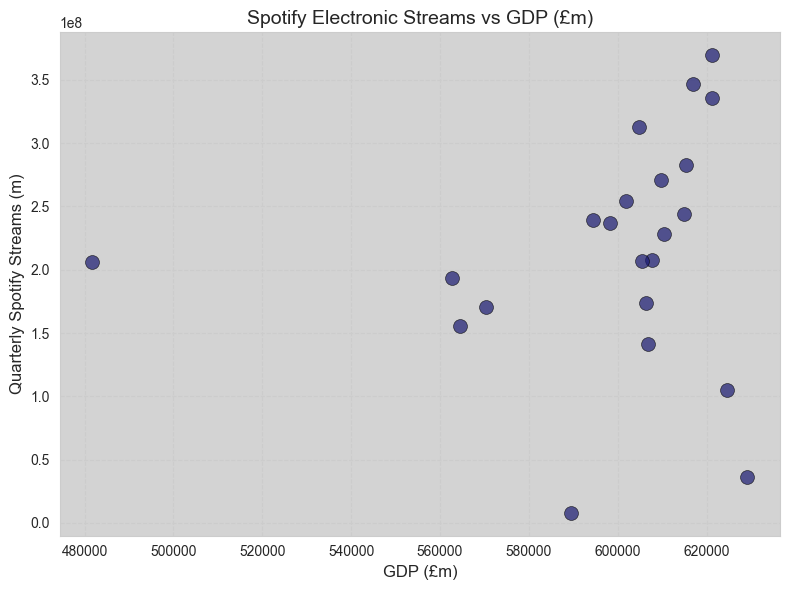

In [24]:
# set electronic_data variable for electronic data 
electronic_data = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Electronic']

# set x and y values 
X = electronic_data['gdp_(£m)'].values  
y = electronic_data['streams'].values  

# creat figure a state size. colour and styling for scatter plot
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.scatter(X, y, color='midnightblue', alpha=0.7, edgecolor='black', linewidth=0.5, s=100)

ax.set_facecolor('lightgrey') 

# labels and title 
ax.set_xlabel('GDP (£m)', fontsize=12)
ax.set_ylabel('Quarterly Spotify Streams (m)', fontsize=12)
ax.set_title('Spotify Electronic Streams vs GDP (£m)', fontsize=14)

plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

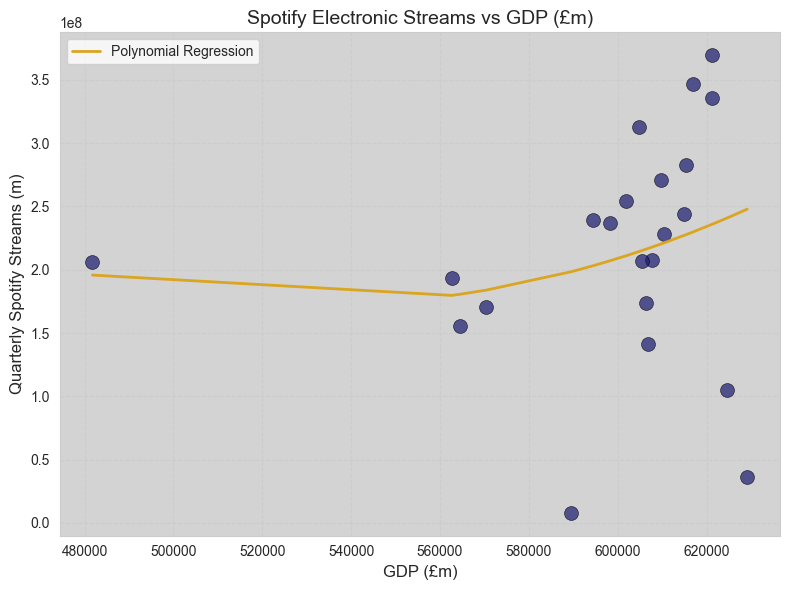

In [26]:
electronic_data = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Electronic']

X = electronic_data['gdp_(£m)'].values.reshape(-1, 1)  
y = electronic_data['streams'].values  

# set polynomial features to help the model learn curves, not just straight lines
# degree=2 means: include squares (x²) and interactions (xy) of all input features
poly = PolynomialFeatures(degree=2)  

# transform the original features (X) into polynomial features (X_poly)
X_poly = poly.fit_transform(X)  

# Initialize a linear regression model now using polynomial features
poly_reg_model = LinearRegression()

# train model on polynomial-transformed features (X_poly) and target (y)
poly_reg_model.fit(X_poly, y)

# predict using the trained model on training data for visualization
y_pred = poly_reg_model.predict(X_poly)

fig, ax = plt.subplots(figsize=(8, 6))  

ax.set_facecolor('lightgrey')        

ax.scatter(X, y, color='midnightblue', alpha=0.7, edgecolor='black', linewidth=0.5, s=100)

X_sorted = np.sort(X, axis=0)

X_sorted_poly = poly.transform(X_sorted)

y_sorted_pred = poly_reg_model.predict(X_sorted_poly)

plt.plot(X_sorted, y_sorted_pred, color='goldenrod', label="Polynomial Regression", linewidth=2)

ax.set_xlabel('GDP (£m)', fontsize=12)
ax.set_ylabel('Quarterly Spotify Streams (m)', fontsize=12)
ax.set_title('Spotify Electronic Streams vs GDP (£m)', fontsize=14)

plt.legend()
plt.grid(linestyle='--')

plt.tight_layout()
plt.show()

### Polynomial Regression of Electronic Music vs GDP

#### Potential Insights:
- Wealthier economies stream more Electronic music: This could be linked to higher disposable income, festival culture.
- The flattening curve at high GDP might suggest a ceiling for streaming growth in this genre with could suggest market saturation.

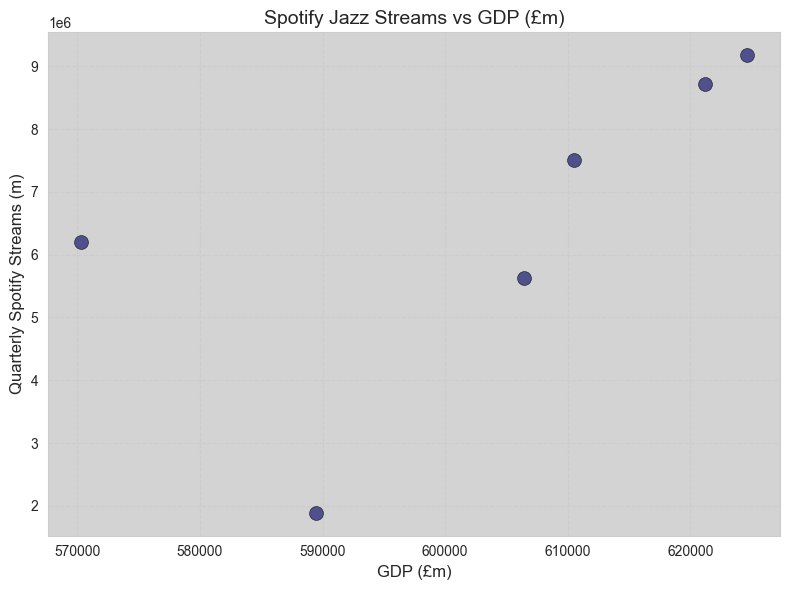

In [27]:
jazz_data = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Jazz']

X = jazz_data['gdp_(£m)'].values 
y = jazz_data['streams'].values 

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X, y, color='midnightblue', alpha=0.7, edgecolor='black', linewidth=0.5, s=100)

ax.set_facecolor('lightgrey') 

ax.set_xlabel('GDP (£m)', fontsize=12)
ax.set_ylabel('Quarterly Spotify Streams (m)', fontsize=12)
ax.set_title('Spotify Jazz Streams vs GDP (£m)', fontsize=14)
    
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

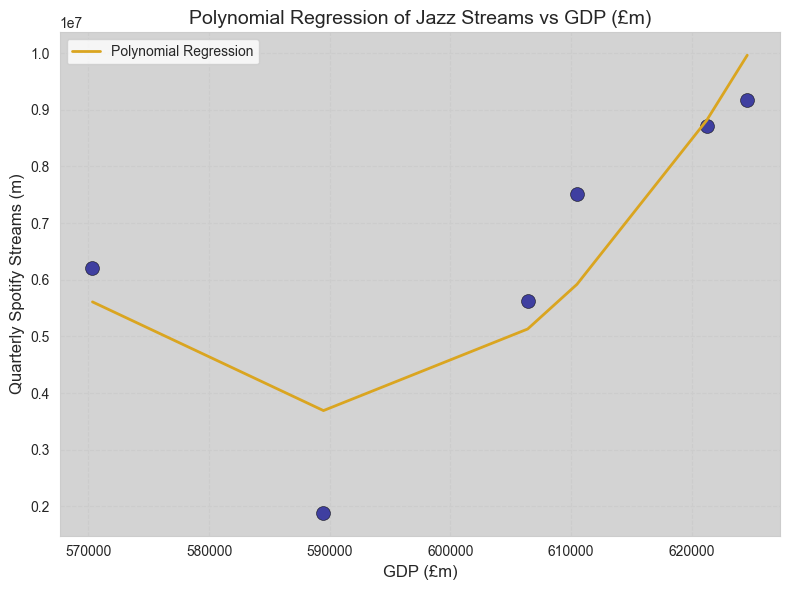

In [28]:
jazz_data = spotify_grouped_df[spotify_grouped_df['Genre_Group'] == 'Jazz']

X = jazz_data['gdp_(£m)'].values.reshape(-1, 1)  
y = jazz_data['streams'].values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

y_pred = poly_reg_model.predict(X_poly)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('lightgrey')

ax.scatter(X, y, color='darkblue', alpha=0.7, edgecolor='black', linewidth=0.5, s=100)

X_sorted = np.sort(X, axis=0)

X_sorted_poly = poly.transform(X_sorted)

y_sorted_pred = poly_reg_model.predict(X_sorted_poly)

plt.plot(X_sorted, y_sorted_pred, color='goldenrod', label="Polynomial Regression", linewidth=2)

ax.set_xlabel('GDP (£m)', fontsize=12)
ax.set_ylabel('Quarterly Spotify Streams (m)', fontsize=12)
ax.set_title('Polynomial Regression of Jazz Streams vs GDP (£m)', fontsize=14)

plt.legend()
plt.grid(linestyle='--')

plt.tight_layout()
plt.show()

### Polynomial Regression of Jazz Music vs GDP

#### Potential Insights:
- Jazz streams might correlate with economic conditions: Higher streams at moderate GDP levels could reflect disposable income for leisure, while drops at very high GDP might indicate shifting consumer preferences.
- Potential outliers: A few points deviate from the curve, which could be suggesting other factors such as seasonality, cultural events may influence streams.

## Summary of Findings, Next Steps and Lessons Learnt:
- Jazz streaming increases at both economic extremes — possibly as a source of comfort during downturns and a cultural indulgence during prosperity. This could suggest Jazz serves multiple emotional roles depending on economic context.
- To take this project further we would need to extract a larger dataset, given a larger sample size our initial insights could be further researched.
- Analysing if macroeconomic factors influenced Spotify listener's streaming behaviour has been an extremely complex topic. To approach this project differently knowing now what we have learnt we would ensure that there was sufficient data. As Spotify launched in late 2008 the data will continue to grow and our hypothesis can be further researched. 